In [1]:
import numpy as np
import cv2
from IPython.display import Video

from matplotlib import pyplot as plt

np.random.seed(2)

In [2]:
#Routine to fix 
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## **Load video**

In [27]:
video = cv2.VideoCapture("VID-20210117-WA0001.mp4")

# Select 30 frames at random
frame_ids = video.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=min(250, video.get(cv2.CAP_PROP_FRAME_COUNT)))

# Store selected frames in array
frames = []
for frame_id in frame_ids:
    video.set(cv2.CAP_PROP_FRAME_COUNT, frame_id)
    ret, frame, = video.read()
    frames.append(frame)
    
video.release()

## **Extract background**

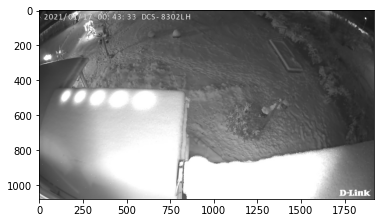

In [28]:
# Calculate the median of every pixel over time to extract the background
medianFrame = np.median(frames, axis=0).astype(dtype=np.uint8)
grayMedianFrame = cv2.cvtColor(medianFrame, cv2.COLOR_BGR2GRAY)
plt.imshow(fixColor(grayMedianFrame))

## **Get moving thing from sample pic420**

**Choose a sample pic**

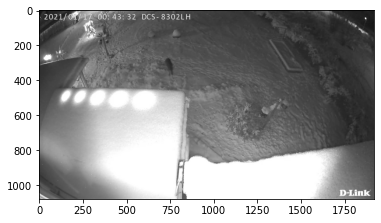

In [29]:
sample = frames[20]
graySample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
plt.imshow(fixColor(graySample))

**Remove background**

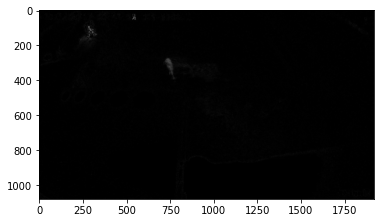

In [30]:
dframe = cv2.absdiff(graySample, grayMedianFrame)
plt.imshow(fixColor(dframe))

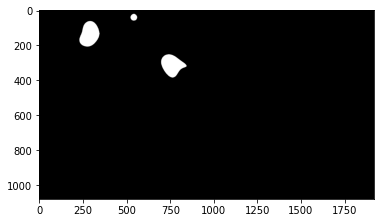

In [31]:
blurred = cv2.GaussianBlur(dframe, (155,155), 0)
ret, tframe= cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(fixColor(tframe))

## **Draw bounding box**

We will create contours using the thresholded pictures

In [32]:
(cnts, _) = cv2.findContours(tframe.copy(), cv2.RETR_EXTERNAL, 
                             cv2 .CHAIN_APPROX_SIMPLE)

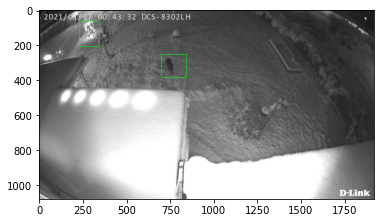

In [33]:
sample_copy = sample.copy()
for cnt in cnts:
    x,y,w,h = cv2.boundingRect(cnt)
    if y > 50:  #Disregard item that are the top of the picture
        cv2.rectangle(sample_copy,(x,y),(x+w,y+h),(0,255,0),2)
        
plt.imshow(fixColor(sample_copy))

In [34]:
plt.imsave("sample_copy.PNG", fixColor(sample_copy))

## **Do for video instead of individual frames**

In [35]:
writer = cv2.VideoWriter("output.mp4", 
                         cv2.VideoWriter_fourcc(*"MP4V"), 30,(640,480))

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [36]:
#Create a new video stream and get total frame count
video_stream = cv2.VideoCapture("VID-20210117-WA0001.mp4")
total_frames=video_stream.get(cv2.CAP_PROP_FRAME_COUNT)
total_frames

420.0

In [37]:
frameCnt=0
while(frameCnt < total_frames-1):

    frameCnt+=1
    ret, frame = video_stream.read()

    # Convert current frame to grayscale
    gframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Calculate absolute difference of current frame and
    # the median frame
    dframe = cv2.absdiff(gframe, grayMedianFrame)
    # Gaussian
    blurred = cv2.GaussianBlur(dframe, (155, 155), 0)
    #Thresholding to binarise
    ret, tframe= cv2.threshold(blurred,0,255,
                               cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #Identifying contours from the threshold
    (cnts, _) = cv2.findContours(tframe.copy(), 
                                 cv2.RETR_EXTERNAL, cv2 .CHAIN_APPROX_SIMPLE)
    #For each contour draw the bounding bos
    for cnt in cnts:
        x,y,w,h = cv2.boundingRect(cnt)
        if y > 50: # Disregard items in the top of the picture
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)

    writer.write(cv2.resize(frame, (640,480)))
 
#Release video object
video_stream.release()
writer.release()